## US Traffic Accidents

## Overview

## Business Understanding

## Data

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.types import DoubleType, StringType, IntegerType, FloatType, LongType, ShortType, BooleanType
from pyspark.sql.functions import min, max, col, regexp_replace, to_date, udf, isnan, when, coalesce, round, split, lower, trim, expr, sum as spark_sum, hour, when, month, year, dayofweek, unix_timestamp, avg, count
from pyspark.ml.classification import RandomForestClassifier
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as stats
from scipy.stats import chi2_contingency, ttest_ind, f_oneway
import statsmodels


## Data Loading

In [2]:
#Population CSV from CENSUS by state in 2023 (end date for traffic accident information
df = pd.read_csv("NST-EST2024-POP.csv")

In [3]:
#Only take two columns needed
col_names = ["2023", "Abbr"]

pop_df = df[col_names]

pop_df

,2023,Abbr
0,"5,117,673",AL
1,"7,473,027",AZ
2,"3,069,463",AR
3,"39,198,693",CA
4,"5,901,339",CO
5,"3,643,023",CT
6,"1,036,423",DE
7,"687,324",DC
8,"22,904,868",FL
9,"11,064,432",GA


In [4]:
#Spark Session
spark = SparkSession.builder \
    .appName("US Traffic Accident Analysis") \
    .getOrCreate()

In [5]:
#Check if active
if (spark.getActiveSession()):
    print('yes')
    print(spark.sparkContext.appName)
else:
    print('no')

yes
US Traffic Accident Analysis


In [6]:
#Load the US traffic accident data into Pyspark DataFrame
traffic_df = spark.read.csv("US_Accidents_March23.csv", header=True, inferSchema=True)



## Data Exploration & Cleaning

In [7]:
traffic_df.show(10)
traffic_df.printSchema

+----+-------+--------+-------------------+-------------------+------------------+------------------+-------+-------+------------+--------------------+--------------------+------------+----------+-----+----------+-------+----------+------------+-------------------+--------------+-------------+-----------+------------+--------------+--------------+---------------+-----------------+-----------------+-------+-----+--------+--------+--------+-------+-------+----------+-------+-----+---------------+--------------+------------+--------------+--------------+-----------------+---------------------+
|  ID| Source|Severity|         Start_Time|           End_Time|         Start_Lat|         Start_Lng|End_Lat|End_Lng|Distance(mi)|         Description|              Street|        City|    County|State|   Zipcode|Country|  Timezone|Airport_Code|  Weather_Timestamp|Temperature(F)|Wind_Chill(F)|Humidity(%)|Pressure(in)|Visibility(mi)|Wind_Direction|Wind_Speed(mph)|Precipitation(in)|Weather_Condition|A

<bound method DataFrame.printSchema of DataFrame[ID: string, Source: string, Severity: int, Start_Time: timestamp, End_Time: timestamp, Start_Lat: double, Start_Lng: double, End_Lat: double, End_Lng: double, Distance(mi): double, Description: string, Street: string, City: string, County: string, State: string, Zipcode: string, Country: string, Timezone: string, Airport_Code: string, Weather_Timestamp: timestamp, Temperature(F): double, Wind_Chill(F): double, Humidity(%): double, Pressure(in): double, Visibility(mi): double, Wind_Direction: string, Wind_Speed(mph): double, Precipitation(in): double, Weather_Condition: string, Amenity: boolean, Bump: boolean, Crossing: boolean, Give_Way: boolean, Junction: boolean, No_Exit: boolean, Railway: boolean, Roundabout: boolean, Station: boolean, Stop: boolean, Traffic_Calming: boolean, Traffic_Signal: boolean, Turning_Loop: boolean, Sunrise_Sunset: string, Civil_Twilight: string, Nautical_Twilight: string, Astronomical_Twilight: string]>

In [8]:
#Drop duplicate rows - there are none after checking
traffic_df = traffic_df.dropDuplicates()

#Remove all null values
df_nonull = traffic_df.dropna()

In [9]:
#Check size of 3 dataframes - 2.5 million rows with null values - about 33% of data
print(traffic_df.count())
#print(traffic_df_cleaned.count())
print(df_nonull.count())

7728394
3554549


In [10]:
null_counts = traffic_df.select([
    spark_sum(col(c).isNull().cast("int")).alias(c) for c in traffic_df.columns
])

null_dict = null_counts.collect()[0].asDict()



In [11]:
null_dict

{'ID': 0,
 'Source': 0,
 'Severity': 0,
 'Start_Time': 0,
 'End_Time': 0,
 'Start_Lat': 0,
 'Start_Lng': 0,
 'End_Lat': 3402762,
 'End_Lng': 3402762,
 'Distance(mi)': 0,
 'Description': 5,
 'Street': 10869,
 'City': 253,
 'County': 0,
 'State': 0,
 'Zipcode': 1915,
 'Country': 0,
 'Timezone': 7808,
 'Airport_Code': 22635,
 'Weather_Timestamp': 120228,
 'Temperature(F)': 163853,
 'Wind_Chill(F)': 1999019,
 'Humidity(%)': 174144,
 'Pressure(in)': 140679,
 'Visibility(mi)': 177098,
 'Wind_Direction': 175206,
 'Wind_Speed(mph)': 571233,
 'Precipitation(in)': 2203586,
 'Weather_Condition': 173459,
 'Amenity': 0,
 'Bump': 0,
 'Crossing': 0,
 'Give_Way': 0,
 'Junction': 0,
 'No_Exit': 0,
 'Railway': 0,
 'Roundabout': 0,
 'Station': 0,
 'Stop': 0,
 'Traffic_Calming': 0,
 'Traffic_Signal': 0,
 'Turning_Loop': 0,
 'Sunrise_Sunset': 23246,
 'Civil_Twilight': 23246,
 'Nautical_Twilight': 23246,
 'Astronomical_Twilight': 23246}

In [12]:
traffic_df = traffic_df.drop("End_Lat", "End_Lng")

In [13]:
traffic_df.columns

['ID',
 'Source',
 'Severity',
 'Start_Time',
 'End_Time',
 'Start_Lat',
 'Start_Lng',
 'Distance(mi)',
 'Description',
 'Street',
 'City',
 'County',
 'State',
 'Zipcode',
 'Country',
 'Timezone',
 'Airport_Code',
 'Weather_Timestamp',
 'Temperature(F)',
 'Wind_Chill(F)',
 'Humidity(%)',
 'Pressure(in)',
 'Visibility(mi)',
 'Wind_Direction',
 'Wind_Speed(mph)',
 'Precipitation(in)',
 'Weather_Condition',
 'Amenity',
 'Bump',
 'Crossing',
 'Give_Way',
 'Junction',
 'No_Exit',
 'Railway',
 'Roundabout',
 'Station',
 'Stop',
 'Traffic_Calming',
 'Traffic_Signal',
 'Turning_Loop',
 'Sunrise_Sunset',
 'Civil_Twilight',
 'Nautical_Twilight',
 'Astronomical_Twilight']

In [14]:
#Checking min value of precipitation to see if its more than 0 - it isn't
min_val = df_nonull.agg(min("Precipitation(in)")).collect()[0][0]

#See how many times its 0.0
count_min = df_nonull.filter(df_nonull["Precipitation(in)"] == min_val).count()
print(f"Minimum value: {min_val}, Count: {count_min}")

Minimum value: 0.0, Count: 3290226


In [15]:
# View all fields and how many unique values there are
for field in traffic_df.schema.fields:
    col_name = field.name
    counts = traffic_df.select(col_name).distinct().count()
    print(f"\n📊 Distinct values in '{col_name}': {counts}")


📊 Distinct values in 'ID': 7728394

📊 Distinct values in 'Source': 3

📊 Distinct values in 'Severity': 4

📊 Distinct values in 'Start_Time': 5801064

📊 Distinct values in 'End_Time': 6463024

📊 Distinct values in 'Start_Lat': 2449172

📊 Distinct values in 'Start_Lng': 2493905

📊 Distinct values in 'Distance(mi)': 22382

📊 Distinct values in 'Description': 3761579

📊 Distinct values in 'Street': 336307

📊 Distinct values in 'City': 13679

📊 Distinct values in 'County': 1871

📊 Distinct values in 'State': 49

📊 Distinct values in 'Zipcode': 825095

📊 Distinct values in 'Country': 1

📊 Distinct values in 'Timezone': 5

📊 Distinct values in 'Airport_Code': 2046

📊 Distinct values in 'Weather_Timestamp': 941332

📊 Distinct values in 'Temperature(F)': 861

📊 Distinct values in 'Wind_Chill(F)': 1002

📊 Distinct values in 'Humidity(%)': 101

📊 Distinct values in 'Pressure(in)': 1145

📊 Distinct values in 'Visibility(mi)': 93

📊 Distinct values in 'Wind_Direction': 25

📊 Distinct values in 'Wi

In [16]:
#Count number of rows where all traffic features are False
target_cols = [
    'Bump', 'Crossing', 'Give_Way', 'Junction', 'No_Exit',
    'Railway', 'Roundabout', 'Station', 'Stop', 'Traffic_Calming',
    'Traffic_Signal', 'Turning_Loop'
]

count_false = traffic_df.filter(
    sum((col(c) == False).cast("int") for c in target_cols) == len(target_cols)
).count()


print(f"All False count: {count_false}")

All False count: 5452028


In [17]:
print(traffic_df.filter(col("Distance(mi)") > 100).count())

traffic_df.filter((col("Distance(mi)") < 10) & (col("Severity") == 4)).count()



86


200287

In [18]:
traffic_df = traffic_df.filter(col("Distance(mi)") <= 100)


## Column Creation

In [19]:
traffic_df = traffic_df.withColumn(
    "time_of_day",
    when((hour("start_time") >= 5) & (hour("start_time") < 12), "Morning")
    .when((hour("start_time") >= 12) & (hour("start_time") < 17), "Afternoon")
    .otherwise("Night")
)

In [20]:
#Get day of week
traffic_df = traffic_df.withColumn("day_of_week_num", dayofweek("start_time"))

In [21]:
traffic_df = traffic_df.withColumn(
    "rush_hour",
    when(
        (
            (dayofweek("start_time").between(2, 6)) &  # Monday (2) to Friday (6)
            (
                ((hour("start_time") >= 6) & (hour("start_time") < 10)) |
                ((hour("start_time") >= 16) & (hour("start_time") < 20))
            )
        ),
        True
    ).otherwise(False)
)

In [22]:
#Get season based on month
traffic_df = traffic_df.withColumn(
    "season",
    when(month("start_time").isin(12, 1, 2), "Winter")
    .when(month("start_time").isin(3, 4, 5), "Spring")
    .when(month("start_time").isin(6, 7, 8), "Summer")
    .otherwise("Fall")
)

In [23]:
#Traffic incident duration in minutes
traffic_df = traffic_df.withColumn(
    "duration_minutes",
    (unix_timestamp("end_time") - unix_timestamp("start_time")) / 60
)

In [24]:
#Dropping columns - lots of Null values or don't see need for them
df = traffic_df.drop("End_lat", "End_lng", "Airport_Code", )

In [25]:
weather_map = {
    "Clear": [
        "Clear", "Fair", "Fair / Windy"
    ],
    "Cloudy": [
        "Cloudy", "Mostly Cloudy", "Scattered Clouds", "Partly Cloudy", "Overcast",
        "Cloudy / Windy", "Partly Cloudy / Windy", "Mostly Cloudy / Windy"
    ],
    "Fog": [
        "Fog", "Shallow Fog", "Patches of Fog", "Light Fog", "Mist", "Haze", "Light Haze",
        "Partial Fog", "Partial Fog / Windy", "Fog / Windy", "Mist / Windy", "Haze / Windy",
        "Shallow Fog / Windy", "Drizzle and Fog", "Patches of Fog / Windy"
    ],
    "Rain": [
        "Rain", "Rain Shower", "Rain Shower / Windy", "Heavy Rain", "Heavy Rain / Windy",
        "Light Rain", "Light Rain / Windy", "Rain / Windy", "Rain Showers", "Heavy Rain Showers",
        "Light Rain Shower", "Light Rain Shower / Windy", "Heavy Rain Shower", "Heavy Rain Shower / Windy",
        "Light Rain Showers", "Showers in the Vicinity"
    ],
    "Drizzle": [
        "Drizzle", "Heavy Drizzle", "Light Drizzle", "Light Drizzle / Windy", "Drizzle / Windy"
    ],
    "Thunderstorm": [
        "Thunder", "Thunderstorm", "Heavy Thunderstorms and Rain", "Heavy Thunderstorms and Snow",
        "Thunderstorms and Rain", "Thunderstorms and Snow", "Heavy T-Storm", "T-Storm", "T-Storm / Windy",
        "Heavy T-Storm / Windy", "Thunder / Windy", "Light Thunderstorm", "Light Rain with Thunder",
        "Light Thunderstorms and Rain", "Light Thunderstorms and Snow", "Thunder / Wintry Mix",
        "Thunder / Wintry Mix / Windy", "Thunder and Hail", "Thunder and Hail / Windy",
        "Snow and Thunder", "Snow and Thunder / Windy", "Heavy Thunderstorms with Small Hail",
        "Heavy Sleet and Thunder", "Thunder in the Vicinity"
    ],
    "Snow": [
        "Snow", "Light Snow", "Heavy Snow", "Light Snow Showers", "Heavy Snow Showers",
        "Snow Showers", "Blowing Snow", "Blowing Snow / Windy", "Heavy Blowing Snow",
        "Light Blowing Snow", "Blowing Snow Nearby", "Light Snow Shower", "Light Snow Shower / Windy",
        "Light Snow Showers", "Drifting Snow", "Drifting Snow / Windy", "Snow / Windy", "Heavy Snow with Thunder", 
        "Heavy Snow / Windy", "Light Snow / Windy", "Light Snow with Thunder", "Low Drifting Snow", "Snow Grains"
    ],
    "Sleet": [
        "Sleet", "Light Sleet", "Heavy Sleet", "Wintry Mix", "Wintry Mix / Windy",
        "Light Snow and Sleet", "Light Snow and Sleet / Windy", "Snow and Sleet",
        "Snow and Sleet / Windy", "Sleet / Windy", "Sleet and Thunder", "Rain and Sleet",
        "Light Sleet / Windy", "Light Snow Grains", "Heavy Sleet / Windy"
    ],
    "Freezing Rain": [
        "Freezing Rain", "Light Freezing Rain", "Heavy Freezing Rain",
        "Freezing Rain / Windy", "Light Freezing Rain / Windy", "Heavy Freezing Rain / Windy",
        "Freezing Drizzle", "Heavy Freezing Drizzle", "Light Freezing Drizzle", "Light Freezing Fog"
    ],
    "Ice Pellets": [
        "Ice Pellets", "Light Ice Pellets", "Heavy Ice Pellets"
    ],
    "Hail": [
        "Hail", "Light Hail", "Small Hail"
    ],
    "Dust/Sand": [
        "Duststorm", "Blowing Dust", "Blowing Dust / Windy", "Sand", "Sand / Windy", "Blowing Sand",
        "Sand / Dust Whirls Nearby", "Sand / Dust Whirlwinds", "Sand / Dust Whirlwinds / Windy",
        "Widespread Dust", "Widespread Dust / Windy", "Dust Whirls", "Squalls", "Squalls / Windy"
    ],
    "Smoke": [
        "Smoke", "Smoke / Windy", "Heavy Smoke"
    ],
    "Tornado": [
        "Funnel Cloud", "Tornado"
    ]
}

In [26]:
# Begin normalization logic
traffic_df = traffic_df.withColumn("Normalized_Weather", col("Weather_Condition"))

# Apply mapping
for label, variants in weather_map.items():
    traffic_df = traffic_df.withColumn(
        "Normalized_Weather",
        when(col("Weather_Condition").isin(variants), label).otherwise(col("Normalized_Weather"))
    )


In [27]:
traffic_df = traffic_df.withColumn(
    "Wind_Direction",
    when(col("Wind_Direction") == "North", "N")
    .when(col("Wind_Direction") == "South", "S")
    .when(col("Wind_Direction") == "East", "E")
    .when(col("Wind_Direction") == "West", "W")
    .when(col("Wind_Direction") == "Variable", "VAR")
    .when(col("Wind_Direction") == "CALM",  "Calm")
    .otherwise(col("Wind_Direction"))
)


In [28]:
feature_cols = [
    "Amenity", "Bump", "Crossing", "Give_Way", "Junction", "No_Exit",
    "Railway", "Roundabout", "Station", "Stop", "Traffic_Calming",
    "Traffic_Signal", "Turning_Loop"
]

traffic_df = traffic_df.withColumn(
    "Traffic_Feature",
    when(
        sum((col(c) == "True").cast("int") for c in feature_cols) >= 1,
        "True"
    ).otherwise("False")
)

In [29]:
traffic_df = traffic_df.withColumn(
    "Visibility_Bucket",
    when(col("Visibility(mi)") <= 0.5, "Very Poor")
    .when((col("Visibility(mi)") > 0.5) & (col("Visibility(mi)") <= 1.0), "Poor")
    .when((col("Visibility(mi)") > 1.0) & (col("Visibility(mi)") <= 3.0), "Moderate")
    .when((col("Visibility(mi)") > 3.0) & (col("Visibility(mi)") <= 6.0), "Fair")
    .when((col("Visibility(mi)") > 6.0) & (col("Visibility(mi)") <= 10.0), "Good")
    .when((col("Visibility(mi)") > 10.0) & (col("Visibility(mi)") <= 75.0), "Excellent")
    .otherwise("Unknown")
)

In [30]:
traffic_df = traffic_df.withColumn(
    "twilight",
    when(
        (col("Civil_Twilight") == True) |
        (col("Nautical_Twilight") == True) |
        (col("Astronomical_Twilight") == True),
        True
    ).otherwise(False)
)


In [31]:
#Fill Null Precipitation values with 0.0
traffic_df = traffic_df.withColumn(
    "Precipitation(in)",
    when(
        col("Precipitation(in)").isNull() & 
        col("Normalized_Weather").isin("Clear", "Cloudy", "Fog"),
        0.0
    ).otherwise(col("Precipitation(in)"))
)


#Fill wind chill Null values with Temperature value
traffic_df = traffic_df.withColumn(
    "Wind_Chill(F)",
    when(
        col("Wind_Chill(F)").isNull() & 
        (col("Wind_Speed(mph)") < 5),
        col("Temperature(F)")
    ).otherwise(col("Wind_Chill(F)"))
)



## DataFrame Creation

In [32]:
#Get numeric columns
numeric_cols = [field.name for field in traffic_df.schema.fields 
                if isinstance(field.dataType, 
                              (DoubleType, IntegerType, FloatType, LongType, ShortType))]

#Get boolean columns
bool_cols = [field.name for field in traffic_df.schema.fields if isinstance(field.dataType, BooleanType)]


#Get average of numeric columsn by severity
severity_df = traffic_df.groupBy("Severity").agg(
    count("*").alias("accident_count"),
    *[avg(col(c)).alias(f"avg_{c}") for c in numeric_cols],
    *[spark_sum(col(b).cast("int")).alias(f"count_true_{b}") for b in bool_cols]
)




In [33]:
pop_spark = spark.createDataFrame(pop_df)

state_df = traffic_df.groupBy("State", "Severity").agg(
    count("*").alias("accident_count"),
    *[avg(col).alias(f"avg_{col}") for col in numeric_cols],
    *[spark_sum(col(b).cast("int")).alias(f"count_true_{b}") for b in bool_cols]
)

state_df = state_df.join(pop_spark, state_df["State"] == pop_spark["Abbr"], how="inner")
state_df = state_df.drop("Abbr")
state_df.show(10)




+-----+--------+--------------+------------+------------------+-------------------+--------------------+------------------+------------------+-----------------+------------------+------------------+-------------------+---------------------+-------------------+--------------------+------------------+---------------+-------------------+-------------------+-------------------+------------------+------------------+---------------------+------------------+---------------+--------------------------+-------------------------+-----------------------+--------------------+-------------------+----------+
|State|Severity|accident_count|avg_Severity|     avg_Start_Lat|      avg_Start_Lng|    avg_Distance(mi)|avg_Temperature(F)| avg_Wind_Chill(F)|  avg_Humidity(%)|  avg_Pressure(in)|avg_Visibility(mi)|avg_Wind_Speed(mph)|avg_Precipitation(in)|avg_day_of_week_num|avg_duration_minutes|count_true_Amenity|count_true_Bump|count_true_Crossing|count_true_Give_Way|count_true_Junction|count_true_No_Exit|coun

In [34]:
weather_df = traffic_df.groupBy("Normalized_Weather", "Severity").agg(
    count("*").alias("accident_count"),
    *[avg(col).alias(f"avg_{col}") for col in numeric_cols],
    *[spark_sum(col(b).cast("int")).alias(f"count_true_{b}") for b in bool_cols]
)

weather_df.show(10)

+------------------+--------+--------------+------------+------------------+------------------+-------------------+------------------+------------------+-----------------+------------------+------------------+-------------------+---------------------+-------------------+--------------------+------------------+---------------+-------------------+-------------------+-------------------+------------------+------------------+---------------------+------------------+---------------+--------------------------+-------------------------+-----------------------+--------------------+-------------------+
|Normalized_Weather|Severity|accident_count|avg_Severity|     avg_Start_Lat|     avg_Start_Lng|   avg_Distance(mi)|avg_Temperature(F)| avg_Wind_Chill(F)|  avg_Humidity(%)|  avg_Pressure(in)|avg_Visibility(mi)|avg_Wind_Speed(mph)|avg_Precipitation(in)|avg_day_of_week_num|avg_duration_minutes|count_true_Amenity|count_true_Bump|count_true_Crossing|count_true_Give_Way|count_true_Junction|count_true_N

In [35]:
feature_df = traffic_df.withColumn("Date", to_date("Start_Time")) \
    .groupBy("Date", "Traffic_Feature") \
    .agg(count("*").alias("accident_count")) \
    .orderBy("Date")


In [36]:
rh_trend_df = traffic_df.withColumn("Date", to_date("Start_Time")) \
    .groupBy("Date", "Rush_Hour") \
    .agg(count("*").alias("accident_count")) \
    .orderBy("Date")




## Chi-Squared Tests

In [37]:
#Chi-square Tests
traffic_pd = traffic_df.select("Normalized_Weather", "Severity").toPandas()
contingency = pd.crosstab(traffic_pd['Normalized_Weather'], traffic_pd['Severity'])
chi2, p, dof, expected = chi2_contingency(contingency)

print("Chi-square:", chi2)
print("p-value:", p)


Chi-square: 38532.02842250485
p-value: 0.0


In [38]:
traffic_pd = traffic_df.select("Season", "Severity").toPandas()
contingency = pd.crosstab(traffic_pd['Season'], traffic_pd['Severity'])
chi2, p, dof, expected = chi2_contingency(contingency)

print("Chi-square:", chi2)
print("p-value:", p)


Chi-square: 109045.33967080842
p-value: 0.0


In [39]:
traffic_pd = traffic_df.select("day_of_week_num", "Severity").toPandas()
contingency = pd.crosstab(traffic_pd['day_of_week_num'], traffic_pd['Severity'])
chi2, p, dof, expected = chi2_contingency(contingency)

print("Chi-square:", chi2)
print("p-value:", p)


Chi-square: 12395.031420778232
p-value: 0.0


In [40]:
traffic_pd = traffic_df.select("Wind_Direction", "Severity").toPandas()
contingency = pd.crosstab(traffic_pd['Wind_Direction'], traffic_pd['Severity'])
chi2, p, dof, expected = chi2_contingency(contingency)

print("Chi-square:", chi2)
print("p-value:", p)

Chi-square: 7897.301338823941
p-value: 0.0


## ANOVA

In [41]:
traffic_pd = traffic_df.select("Visibility(mi)", "Severity").toPandas()
clean_df = traffic_pd.dropna(subset=["Visibility(mi)", "Severity"])

groups = [grp["Visibility(mi)"].values for _, grp in clean_df.groupby("Severity")]
f_stat, p_val = f_oneway(*groups)

print("F-statistic:", f_stat)
print("p-value:", p_val)

F-statistic: 466.4868238151845
p-value: 4.1149662737147075e-303


In [42]:
traffic_pd = traffic_df.select("Precipitation(in)", "Severity").toPandas()
clean_df = traffic_pd.dropna(subset=["Precipitation(in)", "Severity"])

groups = [grp["Precipitation(in)"].values for _, grp in clean_df.groupby("Severity")]
f_stat, p_val = f_oneway(*groups)

print("F-statistic:", f_stat)
print("p-value:", p_val) 

F-statistic: 472.66892181473247
p-value: 3.897138088116835e-307


## File Write

In [43]:
df = traffic_df.drop("End_lat", "End_lng", "Airport_Code", "Description", "Country", "Street", "Weather_Timestamp", "Wind_Chill(F)", 
                     "Weather_Condition", "Wind_Direction", "Amenity", "Bump", "Crossing", "Give_Way", "Junction", "No_Exit", 
                     "Railway", "Roundabout", "Station", "Stop", "Traffic_Calming", "Traffic_Signal", "Turning_Loop", "End_Time", "Zipcode"
                    )

In [44]:
#Remove Null values except for Precipitation and Wind Chill.  Eliminates about 700K rows out of 7.8 million
df_cleaned = df.dropna()

df_cleaned_2 = traffic_df.dropna()

print(df_cleaned.count())
print(df_cleaned_2.count())


7024226
5967898


In [68]:
cols_to_keep = ["ID", "Severity", "Start_Time", "Distance(mi)", "State", "Timezone", "Rush_Hour",
                "Sunrise_Sunset", "time_of_day", "Day_of_week_num", "duration_minutes", "Normalized_Weather", "Visibility_Bucket", "Traffic_Feature"]
    
simple_df = traffic_df.select(cols_to_keep)
simple_df.dropna()

simple_df.count()

7728308

In [69]:
#Write dataframe to csv file
output_path = "file:///home/jovyan/Week11/Capstone1/simple_data"

simple_df.coalesce(1) \
    .write \
    .option("header", "true") \
    .mode("overwrite") \
    .csv(output_path)

In [47]:
#Write dataframe to csv file
output_path = "file:///home/jovyan/Week11/Capstone1/weather_data"

weather_df.coalesce(1) \
    .write \
    .option("header", "true") \
    .mode("overwrite") \
    .csv(output_path)


In [48]:
output_path = "file:///home/jovyan/Week11/Capstone1/severity_data"

severity_df.coalesce(1) \
    .write \
    .option("header", "true") \
    .mode("overwrite") \
    .csv(output_path)


In [49]:
output_path = "file:///home/jovyan/Week11/Capstone1/state_data"

state_df.coalesce(1) \
    .write \
    .option("header", "true") \
    .mode("overwrite") \
    .csv(output_path)


## Business Insight/Recommendation 1

In [53]:
#Snow/Icy conditions equals more severe accidnets

In [54]:
weather_pd = weather_df.toPandas()
severity_pd = severity_df.toPandas()

weather_pd.head()

weather_pd.groupby("Normalized_Weather")["avg_Distance(mi)"].mean()

Normalized_Weather
Clear                0.624065
Cloudy               0.614034
Drizzle              0.592233
Dust/Sand            0.490224
Fog                  0.648163
Freezing Rain        1.153866
Hail                 0.551393
Ice Pellets          0.964862
N/A Precipitation    1.765571
Rain                 0.669081
Sleet                1.063354
Smoke                1.041459
Snow                 1.298949
Thunderstorm         0.782855
Tornado              0.302643
Volcanic Ash         0.024500
Name: avg_Distance(mi), dtype: float64

In [55]:
severity_pd[["Severity", "avg_Distance(mi)"]]

,Severity,avg_Distance(mi)
0,1,0.114507
1,3,0.419725
2,4,1.488163
3,2,0.563927


## Business Insight/Recommendation 2

In [56]:
#Traffic Features minimize accidents and severity of accidents

In [57]:
feature_df = traffic_df.withColumn("Date", to_date("Start_Time")) \
    .groupBy("Date", "Traffic_Feature") \
    .agg(count("*").alias("accident_count")) \
    .orderBy("Date")

feature_pd = feature_df.toPandas()

In [58]:
feature_pd.head()

,Date,Traffic_Feature,accident_count
0,2016-01-14,False,7
1,2016-02-08,False,43
2,2016-02-08,True,17
3,2016-02-09,True,11
4,2016-02-09,False,48


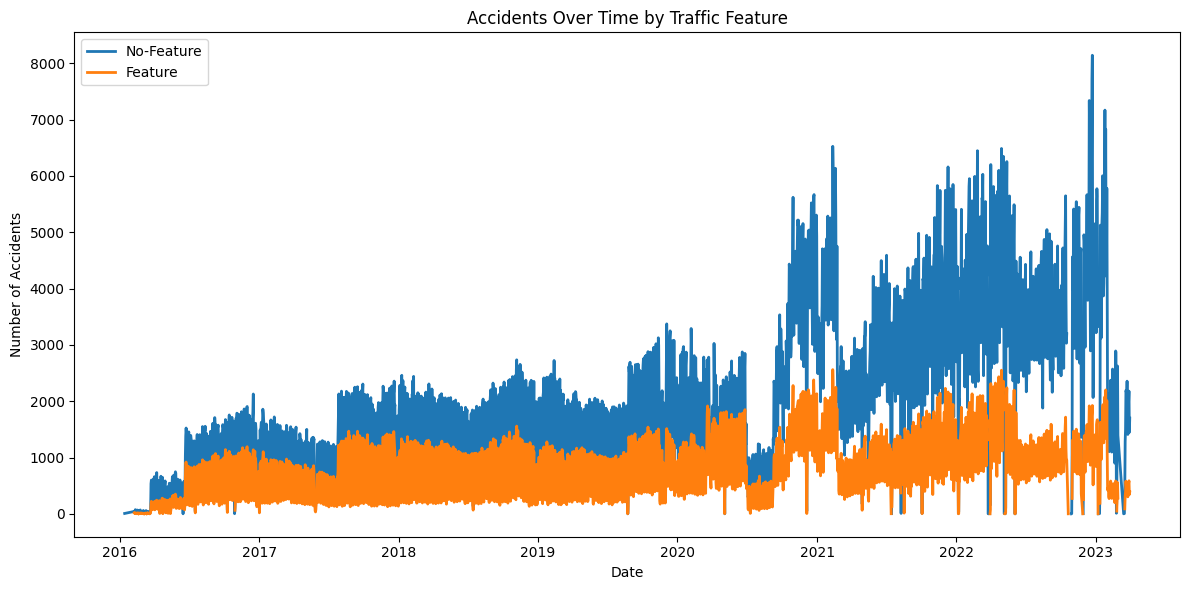

In [59]:
pivot_df = feature_pd.pivot(index="Date", columns="Traffic_Feature", values="accident_count")

pivot_df.plot(figsize=(12, 6), linewidth=2)
plt.title("Accidents Over Time by Traffic Feature")
plt.ylabel("Number of Accidents")
plt.xlabel("Date")
plt.legend(["No-Feature", "Feature"])
plt.tight_layout()
plt.show()


## Business Insight/Recommendation 3

In [60]:
#Rush Hour - wfh and mass transit to minimize

In [61]:
rh_df = traffic_df.select("Start_Time", "ID", "Severity", "Rush_Hour")


In [62]:
trend_df = traffic_df.withColumn("Date", to_date("Start_Time")) \
    .groupBy("Date", "Rush_Hour") \
    .agg(count("*").alias("accident_count")) \
    .orderBy("Date")

trend_pd = trend_df.toPandas()

In [63]:
trend_pd.head()

,Date,Rush_Hour,accident_count
0,2016-01-14,False,7
1,2016-02-08,False,23
2,2016-02-08,True,37
3,2016-02-09,True,42
4,2016-02-09,False,17


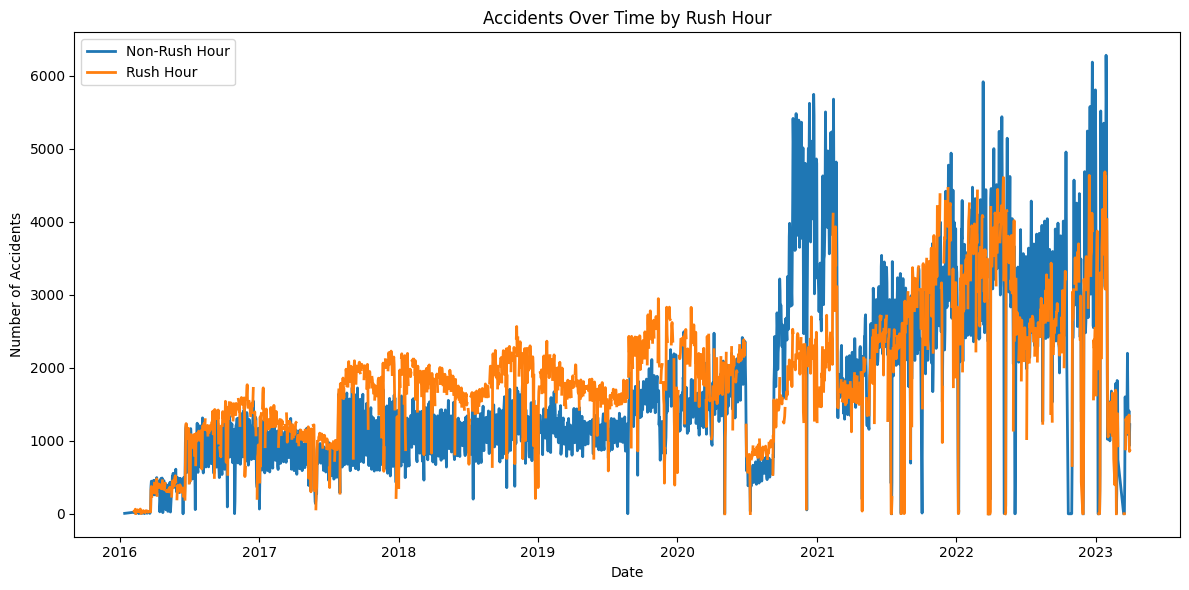

In [64]:
pivot_df = trend_pd.pivot(index="Date", columns="Rush_Hour", values="accident_count")

pivot_df.plot(figsize=(12, 6), linewidth=2)
plt.title("Accidents Over Time by Rush Hour")
plt.ylabel("Number of Accidents")
plt.xlabel("Date")
plt.legend(["Non-Rush Hour", "Rush Hour"])
plt.tight_layout()
plt.show()


## Tableau Link

## Conclusion